## Generative Dialogue Bots

### Description

- #### chat-bot is a computer programme can recieve natural language and process it then output suitable reply ####

 - #### split by the tasks' types, chat-bot can be classified to "free-chat bot", "Q&A bot", "task-based conversation bot" ####

- #### split by the logic of answer, chat-bot can be classified to "retrieval bot" and "generation bot" ####

#### in the below task, basaed on decoder , will implement "generative bot" ####

### Solution

### 1-Single round dialogue

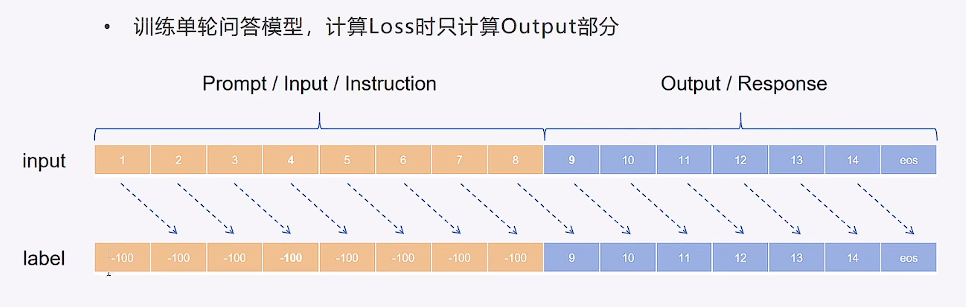

- #### Instruction fine-tuning could give the bot the ability to answer question ####

- #### When training model, only compute "Response/Output" loss, do not compute "Insturction" loss ####

### 2-Multiple rounds dialogue

#### 2-1 Compute loss of last output

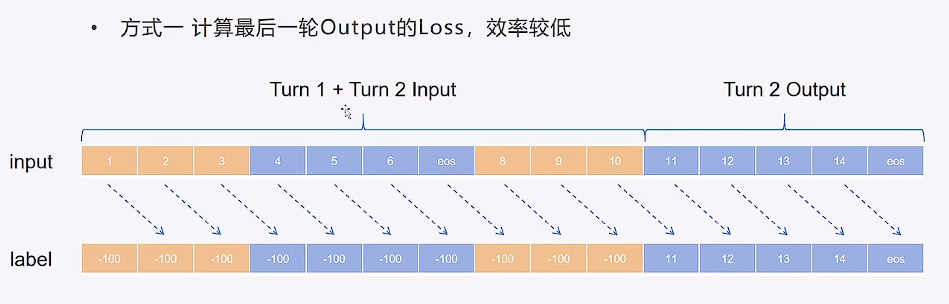

- #### For the implement 1, like single-round, only compute loss of last output ####

- #### It may cause of problems of "Efficiency", because if has 3-rounds dialogue, first step is the computation of first output; second step is computation of combination of "qaq"'s output -- "a", and go on ####

- #### A single data strip need to handled multiple times ####

#### 2-2 Compute loss of every turn's output

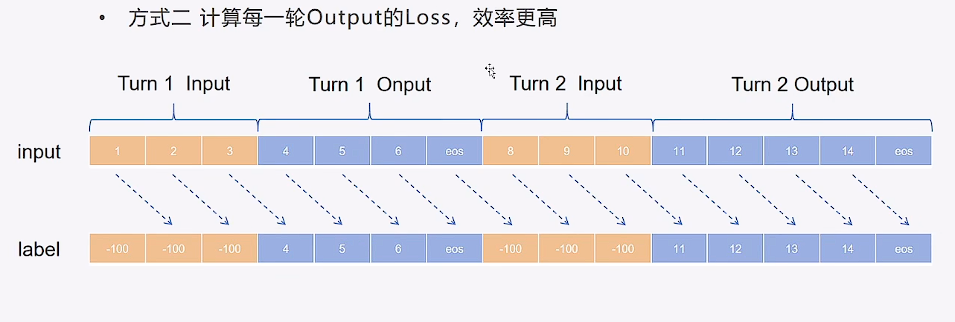

- #### Compute all "Output" in one data strip of every turns ####

- #### It has higher efficiency then 2-1 ####

### Step1 import packs

In [1]:
"""Do not use DataCollatorForLanguageModeling because this datacollate_fn would
make label equal to inputs
"""
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, DataCollatorForSeq2Seq, Trainer, TrainingArguments, pipeline
import torch

### Step2 import data

In [2]:
data = Dataset.load_from_disk("./alpaca_data_zh")
print(data)
print(data[:3])

Dataset({
    features: ['output', 'input', 'instruction'],
    num_rows: 26858
})
{'output': ['以下是保持健康的三个提示：\n\n1. 保持身体活动。每天做适当的身体运动，如散步、跑步或游泳，能促进心血管健康，增强肌肉力量，并有助于减少体重。\n\n2. 均衡饮食。每天食用新鲜的蔬菜、水果、全谷物和脂肪含量低的蛋白质食物，避免高糖、高脂肪和加工食品，以保持健康的饮食习惯。\n\n3. 睡眠充足。睡眠对人体健康至关重要，成年人每天应保证 7-8 小时的睡眠。良好的睡眠有助于减轻压力，促进身体恢复，并提高注意力和记忆力。', '4/16等于1/4是因为我们可以约分分子分母都除以他们的最大公约数4，得到（4÷4）/ (16÷4）=1/4。分数的约分是用分子和分母除以相同的非零整数，来表示分数的一个相同的值，这因为分数实际上表示了分子除以分母，所以即使两个数同时除以同一个非零整数，分数的值也不会改变。所以4/16 和1/4是两种不同的书写形式，但它们的值相等。', '朱利叶斯·凯撒，又称尤利乌斯·恺撒（Julius Caesar）是古罗马的政治家、军事家和作家。他于公元前44年3月15日被刺杀。 \n\n根据历史记载，当时罗马元老院里一些参议员联合起来策划了对恺撒的刺杀行动，因为他们担心恺撒的统治将给罗马共和制带来威胁。在公元前44年3月15日（又称“3月的艾达之日”），恺撒去参加元老院会议时，被一群参议员包围并被攻击致死。据记载，他身中23刀，其中一刀最终致命。'], 'input': ['', '输入：4/16', ''], 'instruction': ['保持健康的三个提示。', '解释为什么以下分数等同于1/4', '朱利叶斯·凯撒是如何死亡的？']}


### Step3 data process

In [3]:
tokenizer = AutoTokenizer.from_pretrained("./langboat-bloom-zh-389m")
tokenizer

BloomTokenizerFast(name_or_path='./langboat-bloom-zh-389m', vocab_size=42437, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>'}, clean_up_tokenization_spaces=False)

In [8]:
def preprocess_func(example, tokenizer=tokenizer):
    MAX_LENGTH = 256
    input_ids = []
    attention_mask = []
    labels = []
    instruction = tokenizer("\n".join(["Human: " + example["instruction"], example["input"]]).strip() + "\n\nAssistant: ")
    response = tokenizer(example["output"] + tokenizer.eos_token)
    input_ids = instruction["input_ids"] + response["input_ids"]
    attention_mask = instruction["attention_mask"] + response["attention_mask"]
    labels = [-100] * len(instruction["input_ids"]) + response["input_ids"]
    if len(input_ids) > MAX_LENGTH:
        input_ids = input_ids[:MAX_LENGTH]
        attention_mask = attention_mask[:MAX_LENGTH]
        labels = labels[:MAX_LENGTH]

    return {
        "input_ids":input_ids,
        "attention_mask":attention_mask,
        "labels":labels,
    }

In [9]:
"""do not config "batched=True"
or it will occur type error of concatenation of str to str
"""
tokenized_data = data.map(preprocess_func, remove_columns=data.column_names)
print(tokenized_data)
print(tokenized_data[0])

Map:   0%|          | 0/26858 [00:00<?, ? examples/s]

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 26858
})
{'input_ids': [23069, 29, 210, 6583, 24772, 8995, 13533, 671, 189, 4122, 15263, 29, 210, 4744, 583, 6583, 24772, 8995, 13533, 1022, 189, 189, 20, 17, 210, 6583, 8416, 3228, 420, 8634, 1900, 13648, 8416, 5625, 355, 1202, 29011, 553, 30355, 1298, 15599, 355, 961, 4872, 34650, 5980, 355, 10915, 15342, 7761, 355, 1403, 11472, 6189, 20465, 671, 189, 21, 17, 210, 20122, 13660, 420, 8634, 13869, 20189, 373, 17070, 553, 16382, 553, 1204, 6165, 1430, 641, 14562, 16130, 24251, 15502, 7984, 355, 7981, 1220, 6538, 553, 1220, 14562, 641, 13545, 10249, 355, 714, 6583, 24772, 13660, 11297, 671, 189, 22, 17, 210, 17672, 16272, 420, 17672, 1063, 13966, 5980, 18688, 355, 30645, 8634, 1638, 7900, 954, 3779, 210, 38858, 17672, 420, 14054, 17672, 11472, 15375, 10891, 355, 4872, 8416, 7442, 355, 1403, 5323, 4001, 16885, 14721, 1249, 420, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

### Step4 creat model

In [10]:
bloom_lm = AutoModelForCausalLM.from_pretrained("./langboat-bloom-zh-389m")
print("bloom model imported")

bloom model imported


### Step5 parameters configuration

In [11]:
train_args = TrainingArguments(
    output_dir="./chatbot-bloom",
    save_strategy="epoch",
    save_total_limit=3,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=8,
    logging_steps=80,
    num_train_epochs=3,
)

### Step6 creat trainer

In [12]:
trainer = Trainer(
    model=bloom_lm,
    args=train_args,
    train_dataset=tokenized_data,
    data_collator=DataCollatorForSeq2Seq(tokenizer=tokenizer, padding=True)
)

### Step7 model training

In [ ]:
trainer.train()

### Step8 model inference

In [ ]:
pipe = pipeline("text-generation", model=bloom_lm, tokenizer=tokenizer, device=0)

instruction = ""
inputs = ""
pipe(f"Human: {instruction}\n{inputs}".strip() + "\n\nAssistant: ", max_length=256, do_sample=True)

### Common inference parameters

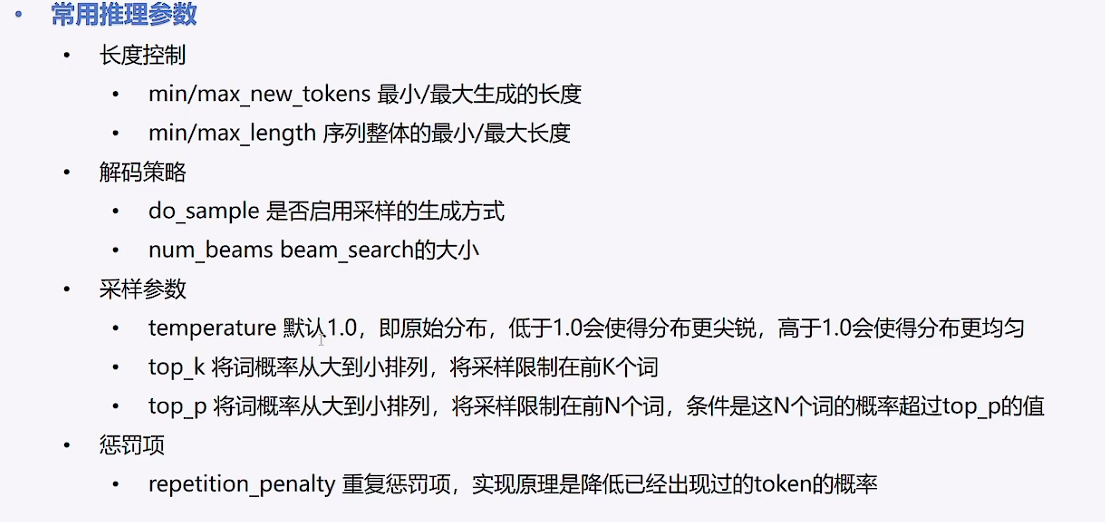